## 镜像钟异常数据检测 （基于Random Pursuit Extrapolation）

In [1]:
import numpy as np
import pandas as pd
import allantools
import random

import matplotlib.pyplot as plt
%matplotlib inline

### 1. Noise Removal

There are several ways to remove the noise: Minus Optical Frequency Atomic Clock or by filtering

In [2]:
minus_optical_data_dir = '/opt/beamformer/GAN/data/real_after_30000.csv'
FIR_data_dir = '/opt/beamformer/GAN/data/filtered_data.csv'

df_minus_optical_data_all = pd.read_csv(minus_optical_data_dir, header = None)
df_FIR_data = pd.read_csv(FIR_data_dir, header = None)

print(df_minus_optical_data_all.head(5))
print('---------------------------------------------------------------------------------')
print(df_FIR_data.head(5))

              0             1             2             3             4
0 -4.537900e-14 -1.173813e-13 -4.935266e-14  5.261262e-14  3.341675e-14
1 -2.265000e-14 -1.012483e-13 -2.193466e-14  7.542133e-14  5.472819e-14
2 -2.400067e-14 -1.073680e-13 -3.274267e-14  7.192254e-14  4.664103e-14
3 -3.465033e-14 -1.099903e-13 -3.329933e-14  6.341656e-14  4.328410e-14
4 -4.402800e-14 -1.180173e-13 -4.402800e-14  5.793730e-14  3.468831e-14
---------------------------------------------------------------------------------
              0             1             2             3             4
0 -3.186127e-14 -1.042013e-13 -3.368007e-14  7.139593e-14  4.629043e-14
1 -3.329154e-14 -1.050449e-13 -3.480009e-14  7.011645e-14  4.475857e-14
2 -3.232515e-14 -1.039899e-13 -3.387485e-14  7.111891e-14  4.525628e-14
3 -3.188633e-14 -1.039053e-13 -3.381625e-14  7.073285e-14  4.516182e-14
4 -3.225678e-14 -1.042485e-13 -3.383386e-14  7.039006e-14  4.487599e-14


In [3]:
# NOTE: We only use 3 clocks out of 5
df_minus_optical_data = df_minus_optical_data_all.iloc[:,1:4]

taus - [1.0000e+00 2.0000e+00 4.0000e+00 8.0000e+00 1.6000e+01 3.2000e+01
 6.4000e+01 1.2800e+02 2.5600e+02 5.1200e+02 1.0240e+03 2.0480e+03
 4.0960e+03 8.1920e+03 1.6384e+04]
adevs - [8.62941227e-15 4.80745940e-15 2.81686893e-15 2.30855263e-15
 1.91517625e-15 1.52644771e-15 1.14856427e-15 8.25145040e-16
 6.40353514e-16 4.97971238e-16 4.82286071e-16 5.89988237e-16
 1.03310482e-15 2.04180207e-15 4.11935315e-15]
----------------------------------------
taus - [1.0000e+00 2.0000e+00 4.0000e+00 8.0000e+00 1.6000e+01 3.2000e+01
 6.4000e+01 1.2800e+02 2.5600e+02 5.1200e+02 1.0240e+03 2.0480e+03
 4.0960e+03 8.1920e+03 1.6384e+04]
adevs - [8.56004643e-15 4.65528123e-15 2.52071931e-15 1.92582714e-15
 1.60668913e-15 1.30907023e-15 1.02082863e-15 7.13577087e-16
 5.64153377e-16 4.02652984e-16 3.50001067e-16 3.26666782e-16
 4.55192255e-16 8.39947833e-16 1.56480677e-15]
----------------------------------------
taus - [1.0000e+00 2.0000e+00 4.0000e+00 8.0000e+00 1.6000e+01 3.2000e+01
 6.4000e+01 1.28

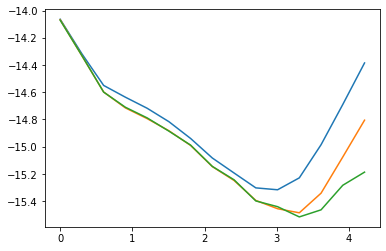

In [4]:
for i in range(df_minus_optical_data.shape[1]):
    (taus, adevs, errors, ns) = allantools.adev(data=df_minus_optical_data.iloc[:,i].to_numpy(), data_type='freq')
    print('taus - %s' % taus)
    print('adevs - %s' % adevs)
    print("----------------------------------------")
    plt.plot(np.log10(taus), np.log10(adevs))
plt.show()

### 2. Learning weight with Inverse Variance

Use traditional inverse variance to learn the weight for each H-maser

In [5]:
def inverse_variance(clock_data:np.ndarray, window_size:int, start_inx:int = 0, tau_level:int = 3):
    # clock_data: array with shape - number_records * number_clock
    # window_size: number of records within the calculation window
    # start_idx: start record index of the window, default is 0
    # tau_level: using allan variance for tau = 2 ** tau_level, default is tau = 8
    inverse_variance = list()

    for k in range(clock_data.shape[1]):
        clock = clock_data[start_inx:start_inx + window_size, k]
        (taus, adevs, errors, ns) = allantools.adev(data=clock, data_type='freq')
        inverse_variance.append(1.0 / (adevs[tau_level + 1] ** 2))

    inverse_variance = np.array(inverse_variance) / np.sum(np.array(inverse_variance))
    return inverse_variance

In [6]:
inverse_variance_start_idx = 0
inverse_variance_window_size = int(60 / 5 * 24) # 24 hours, 1 point every 5 min
clock_arr = df_minus_optical_data.to_numpy()
inverse_variance_weights = inverse_variance(clock_arr, inverse_variance_window_size, inverse_variance_start_idx)
print(inverse_variance_weights)

[0.18309078 0.42019643 0.39671279]


### 3. Sigma calculation

In [7]:
def cal_sigmas(clock_data:np.ndarray, window_size:int, start_inx:int = 0):
    clocks = clock_data[start_inx:start_inx + window_size, :]
    sigmas = np.std(clocks, axis=0)
    return sigmas

In [8]:
sigmas = cal_sigmas(clock_arr, inverse_variance_window_size, inverse_variance_start_idx)
print(sigmas)

[6.99350707e-15 6.61503707e-15 6.78670864e-15]


### 4. Jump generation

In [9]:
rp_start_inx = inverse_variance_start_idx + inverse_variance_window_size
rp_window_size = 12 * 24     # 24 hours, 1 point every 5 min
N = 12 * 6                   # 6 hours, 1 point every 5 min
s_size = 1
#n_pred = clock_arr.shape[0] - (rp_start_inx + rp_window_size) - 1
n_pred = 20000
remaining_size = clock_arr.shape[0] - inverse_variance_window_size

print('**************************** SUMMARY ****************************')
print('Original Data Shape: %s' % str(clock_arr.shape))
print('Inverse Variance Shape: (%s, %s)' % (inverse_variance_window_size, clock_arr.shape[1]))
print('Remaining Data Shape: (%s, %s)' % (remaining_size, clock_arr.shape[1]))
print('Random Pursuit Start Index %s and Window Size: %s' % (rp_start_inx, rp_window_size))
print('Random Pursuit Values to predict: %s' % n_pred)

**************************** SUMMARY ****************************
Original Data Shape: (74271, 3)
Inverse Variance Shape: (288, 3)
Remaining Data Shape: (73983, 3)
Random Pursuit Start Index 288 and Window Size: 288
Random Pursuit Values to predict: 20000


In [10]:
def generate_jump(jump_lower_bound:float, jump_higher_bound:float, clock_remaining_size:int, rand_keep_size:int,
                  sigmas:np.array, jump_clock_idx:list, if_same_idx:bool, if_same_direction:bool):
    """generate random jump.
    # Arguments
        jump_lower_bound: Float, lower bound of jump, number of sigmas.
        jump_higher_bound: Float, upper bound of jump, number of sigmas.
        clock_remaining_size: Integer, size of one clock.
        rand_keep_size: Integer, size of random jumps. Should be less than clock_remaining_size.
        sigmas: Ndarray, with shape (num_clocks, ). sigma for each clock.
        jump_clock_idx: A list, contains the index of jump clocks.
        if_same_idx: Boolean, if the clocks in list jump_clock_idx jumps at the same index.
        if_same_direction: Boolean, if the clocks in list jump_clock_idx jumps in the same direction.

    # Returns
        jumps: Ndarray, with shape (clock_remaining_size, num_clocks), contains the jump value for each clock at each time point.
        jump_idx_list:  Ndarray, with shape (rand_keep_size, 1), contains the index of jumps.
    """
    
    rand_keep_idx_list = list()
    jump_amplifer = np.random.uniform(jump_lower_bound, jump_higher_bound, (clock_remaining_size, 1))
    zeros = np.zeros((clock_remaining_size, sigmas.shape[0]))
    rand_keep_idx = random.sample(range(clock_remaining_size), rand_keep_size)
    neg_idx = random.sample(rand_keep_idx, len(rand_keep_idx) // 2)

    if len(jump_clock_idx) == 1:
        print('1 clock jumps, the index is %s' % jump_clock_idx[0])
        zeros[rand_keep_idx,jump_clock_idx[0]] = jump_amplifer[rand_keep_idx,0] * sigmas[jump_clock_idx[0]]
        zeros[neg_idx,i] = zeros[neg_idx,i] * (-1)
        rand_keep_idx_list.append(rand_keep_idx)
    elif len(jump_clock_idx) == 2:
        if if_same_idx:
            if if_same_direction:
                print('2 clocks jump in same direction, the index are %s' % str(jump_clock_idx))
                for idx in jump_clock_idx:
                    zeros[rand_keep_idx,idx] = jump_amplifer[rand_keep_idx,0] * sigmas[idx]
                    zeros[neg_idx,idx] = zeros[neg_idx,idx] * (-1)
                    rand_keep_idx_list.append(rand_keep_idx)
            else:
                print('2 clocks jump in different direction, the index are %s' % str(jump_clock_idx))
                switch = 1
                for idx in jump_clock_idx:
                    zeros[rand_keep_idx,idx] = jump_amplifer[rand_keep_idx,0] * sigmas[idx] * switch
                    zeros[neg_idx,idx] = zeros[neg_idx,idx] * (-1) * switch
                    rand_keep_idx_list.append(rand_keep_idx)
                    switch *= -1
        else:
            raise Exception('Goes back to 1 clock jump scenenario. Exit')
    else:
        raise Exception('Length of jump_clock_idx should be 1 or 2. Exit')

    return zeros, np.array(rand_keep_idx_list).T

In [11]:
# For 1 jump
# jump_lower_bound = 3.0
# jump_higher_bound = 5.0
jump_lower_bound = 5.0
jump_higher_bound = 10.0
rand_keep_size = 4000
jump_clock_idx = [0,1]

# Works only when len(jump_clock_idx) == 2
if_same_idx = True
if_same_direction = True

jumps, jump_idx_list = generate_jump(jump_lower_bound, jump_higher_bound, remaining_size-rp_start_inx, rand_keep_size, sigmas, jump_clock_idx, if_same_idx, if_same_direction)

2 clocks jump in same direction, the index are [0, 1]


In [12]:
final_jumps = np.concatenate((np.zeros((rp_window_size, clock_arr.shape[1])), jumps), axis=0)

print('Jumps Data Shape: %s' % str(jumps.shape))
print('Jumps only exists after index: %s' % rp_start_inx)
print('By adding Zeros, Final Jumps Data Shape: %s' % str(final_jumps.shape))
print('Random Jump Index Shape: %s' % str(jump_idx_list.shape))
clock_rp_arr = clock_arr[rp_start_inx:,]
clock_rp_arr_with_jumps = clock_rp_arr + final_jumps

Jumps Data Shape: (73695, 3)
Jumps only exists after index: 288
By adding Zeros, Final Jumps Data Shape: (73983, 3)
Random Jump Index Shape: (4000, 2)


### 5. Drift learning and Extrapolation with Random Pursuit

Use random pursuit to learn the weight for each H-maser

In [13]:
# Minus H-ensemble first
clock_rp_ensemble = np.dot(clock_rp_arr_with_jumps, inverse_variance_weights)
clock_rp_minus_ensemble = clock_rp_arr_with_jumps - clock_rp_ensemble.reshape(-1,1)
print('After minus ensemble Data, has Shape: %s' % str(clock_rp_minus_ensemble.shape))

After minus ensemble Data, has Shape: (73983, 3)


In [14]:
#for i in range(clock_rp_minus_ensemble.shape[1]):
    #clock_x = clock_rp_minus_ensemble[:,i]
    #clock_y = clock_rp_minus_ensemble[rp_window_size:,i]

In [15]:
def get_real_jumps(clock_y, rolling_window_size, rolling_step_size, threshold, rp_start_inx):
    jumps = set()
    num_iter = (len(clock_y) - rolling_window_size) // rolling_step_size + 1
    
    for i in range(0, num_iter):
        this_iter_data = clock_y[i * rolling_step_size : i * rolling_step_size + rolling_window_size] 
        bool_jumps = np.abs(this_iter_data - np.mean(this_iter_data)) >= threshold
        this_iter_jumps = np.array([i for i in range(i * rolling_step_size, i * rolling_step_size + rolling_window_size)])[bool_jumps]
        # NOTE: Need to minus rp_start_inx, as we add jumps after rp_start_inx
        jumps.update(list(this_iter_jumps - rp_start_inx))
        
    return sorted(list(jumps))

In [16]:
import random_pursuit
'''
        data_x: A ndarray, a series x value.
        data_y: A ndarray, corresponding series of y value.
        inx_h: Integer, max index of history data.
        l_inx: Integer, length of history data used for pursuit. Or say, the size of sliding window.
        N: Interger, number of points in each regression.
        inx_p: Integer, the index of the data point to predict. If set to -1, the point with index (inx_h+1) will be predicted.
        n_pred: Interger, number of points to predict with sliding window.
        s_size: Interger, the moving step size of sliding window.
        percent_value: Float, max percentage for weight recaculation.
        method: String, 'inverse' or 'softmax', how weights are calculated from losses
'''

clock_rp_extrapolation_list = list()

#for i in jump_clock_idx:
for i in [0]:    
    print('****************************** Clock %s ******************************' % i)
    clock_x = np.arange(clock_rp_minus_ensemble.shape[0]).reshape(-1,1) * 300  # 1 point every 5 minute
    clock_y = clock_rp_minus_ensemble[:,i]
    inx_h = rp_window_size - 1
    l_inx = rp_window_size
    N = N
    n_pred = n_pred
    s_size = s_size
    method = 'inverse'
    threshold = 3 * sigmas[i]
    
    rolling_window_size = 500
    rolling_step_size = 1
    
    real_jumps = get_real_jumps(clock_y, rolling_window_size, rolling_step_size, threshold, rp_start_inx)
    
    clock_pred_results, alert_idxs, refined_clock_y, rp_real_jumps = random_pursuit.random_pursuit(
        data_x = clock_x, 
        data_y = clock_y, 
        threshold = threshold,
        inx_h = inx_h, 
        l_inx = l_inx, 
        N = N,
        inx_p = -1, 
        n_pred = n_pred, 
        s_size = s_size, 
        percent_value = -1, 
        with_self_resid = False,
        method = method
    )
    clock_rp_extrapolation_list.append(clock_pred_results)

****************************** Clock 0 ******************************
Initiate - Shuffled inx with shape: (72, 4)
... ... This is iteration 500 ... ...
... ... This is iteration 1000 ... ...
... ... This is iteration 1500 ... ...
... ... This is iteration 2000 ... ...
... ... This is iteration 2500 ... ...
... ... This is iteration 3000 ... ...
... ... This is iteration 3500 ... ...
... ... This is iteration 4000 ... ...
... ... This is iteration 4500 ... ...
... ... This is iteration 5000 ... ...
... ... This is iteration 5500 ... ...
... ... This is iteration 6000 ... ...
... ... This is iteration 6500 ... ...
... ... This is iteration 7000 ... ...
... ... This is iteration 7500 ... ...
... ... This is iteration 8000 ... ...
... ... This is iteration 8500 ... ...
... ... This is iteration 9000 ... ...
... ... This is iteration 9500 ... ...
... ... This is iteration 10000 ... ...
... ... This is iteration 10500 ... ...
... ... This is iteration 11000 ... ...
... ... This is iteration 

In [17]:
from pylab import plot, show, grid, xlabel, ylabel

In [18]:
(taus_origin, adevs_origin, errors, ns) = allantools.adev(data=clock_y[:n_pred], data_type='freq')
print('taus - %s, adevs - %s' % (taus_origin, adevs_origin))

taus - [1.000e+00 2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.400e+01
 1.280e+02 2.560e+02 5.120e+02 1.024e+03 2.048e+03 4.096e+03], adevs - [5.79925244e-15 4.11602376e-15 2.99438429e-15 2.36806135e-15
 1.84550512e-15 1.36595211e-15 9.74846985e-16 7.49677874e-16
 5.51052750e-16 4.09121521e-16 2.82138852e-16 4.14866851e-16
 8.30196068e-16]


In [19]:
(taus_refined, adevs_refined, errors, ns) = allantools.adev(data=refined_clock_y[:n_pred], data_type='freq')
print('taus - %s, adevs - %s' % (taus_refined, adevs_refined))

taus - [1.000e+00 2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.400e+01
 1.280e+02 2.560e+02 5.120e+02 1.024e+03 2.048e+03 4.096e+03], adevs - [3.63378565e-15 2.59086398e-15 1.95582220e-15 1.59257969e-15
 1.32433413e-15 1.00816187e-15 7.82904835e-16 6.32007627e-16
 5.06425410e-16 3.65630881e-16 2.40355324e-16 4.10821985e-16
 7.94351553e-16]


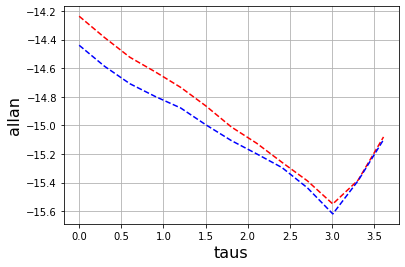

In [20]:
# https://pydatascience.org/2017/11/24/plot-multiple-lines-in-one-chart-with-different-style-python-matplotlib/
plot(np.log10(taus_origin), np.log10(adevs_origin), 'r--', np.log10(taus_refined), np.log10(adevs_refined), 'b--')
xlabel('taus', fontsize=16)
ylabel('allan', fontsize=16)
grid(True)
show()

### 6. Performance evaluation

Evaluate the stability and prediction accuracy

In [21]:
clock_idx = 0
print('The clock to evaluate performance is %s' % clock_idx)

The clock to evaluate performance is 0


In [22]:
real_clock_arr = clock_rp_minus_ensemble[rp_window_size:rp_window_size+n_pred,clock_idx]

In [23]:
clock_pred_results = clock_rp_extrapolation_list[0]
clock_pred_arr = np.array([clock_pred_results[i] for i in range(n_pred)])

In [24]:
jump_idx = jump_idx_list[:,0] < n_pred
print('Number of jump points are: %s' % rand_keep_size)
print('For inx < %s, there are %s jump points' % (n_pred, np.sum(jump_idx)))

Number of jump points are: 4000
For inx < 20000, there are 1107 jump points


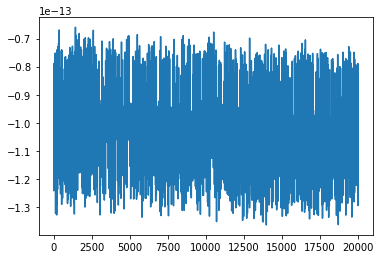

In [25]:
plt.plot(real_clock_arr)

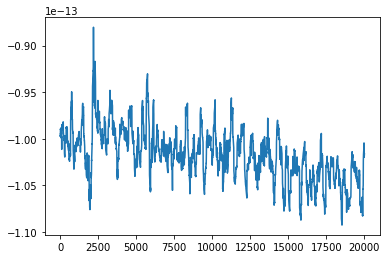

In [26]:
plt.plot(clock_pred_arr)

In [27]:
np.savetxt('txt-图7-1添加了跳变的第一台氢钟和其镜像原子钟的频率曲线.txt', real_clock_arr, delimiter=',')

In [28]:
np.savetxt('txt-图7-2添加了跳变的第一台氢钟和其镜像原子钟的频率曲线.txt', clock_pred_arr, delimiter=',')

In [29]:
print("Number data alert: %s" % len(alert_idxs))

Number data alert: 656


In [30]:
# beyond_3_sigma = np.abs(real_clock_arr - clock_pred_arr) >= 3 * sigmas[clock_idx]
# print("Number data beyond 3 sigma: %s" % np.sum(beyond_3_sigma))
# print(np.where(beyond_3_sigma)[0])

In [31]:
jump_idx_before_n_pred = jump_idx_list[(jump_idx_list[:,0] < n_pred), 0]

print("Number data has jump: %s" % jump_idx_before_n_pred.shape[0])
print(np.sort(jump_idx_before_n_pred))

Number data has jump: 1107
[    5    20    21 ... 19975 19988 19993]


In [32]:
def cal_precision_recall(true_list, pred_list):
    count = 0
    for item in true_list:
        if item in pred_list:
            count += 1
    return count / len(true_list), count / len(pred_list)

In [33]:
precision, recall = cal_precision_recall(list(jump_idx_before_n_pred), alert_idxs)
print("Number Jumps Added: %s" % len(list(jump_idx_before_n_pred)))
print("Number Jumps Predicted: %s" % len(alert_idxs))
print("Precision: %s" % precision)
print("Recall: %s" % recall)

Number Jumps Added: 1107
Number Jumps Predicted: 656
Precision: 0.5925925925925926
Recall: 1.0


In [34]:
real_jumps_20000 = list()
for i in real_jumps:
    if i <= 20000:
        real_jumps_20000.append(i)

In [35]:
precision, recall = cal_precision_recall(real_jumps_20000, alert_idxs)
print("Number Real Jumps: %s" % len(real_jumps_20000))
print("Precision: %s" % precision)
print("Recall: %s" % recall)

Number Real Jumps: 684
Precision: 0.8903508771929824
Recall: 0.9283536585365854


In [36]:
rp_real_jumps_20000 = list()
for i in rp_real_jumps:
    # NOTE: Need to minus rp_start_inx, as we add jumps after rp_start_inx
    if i - rp_start_inx <= 20000:
        rp_real_jumps_20000.append(i - rp_start_inx)

In [37]:
precision, recall = cal_precision_recall(rp_real_jumps_20000, alert_idxs)
print("Number RP Real Jumps: %s" % len(rp_real_jumps_20000))
print("Precision: %s" % precision)
print("Recall: %s" % recall)

Number RP Real Jumps: 687
Precision: 0.8908296943231441
Recall: 0.9329268292682927
